<a href="https://colab.research.google.com/github/adxpillar/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/Adewale_Adeagbo_LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [0]:
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)

In [0]:
df.head()

In [0]:
df['Year'] = df['Date'].dt.year

In [0]:
df.shape

(421, 60)

In [0]:
df.isnull().sum()

In [0]:
df.head(3)

In [0]:
df = df.drop(columns=['Burrito', 'Yelp', 'Google', 'Chips',
                      'Mass (g)', 'Density (g/mL)', 'Length', 'Circum', 'Volume',
                      'Unreliable', 'NonSD', 'Beef', 'Pico', 'Guac','Date',
                      'Cheese', 'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp', 'Fish',
                      'Rice', 'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots',
                      'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito',
                      'Pineapple', 'Ham', 'Chile relleno', 'Nopales', 'Lobster', 'Queso',
                      'Egg', 'Mushroom', 'Bacon', 'Sushi', 'Avocado', 'Corn', 'Zucchini'])

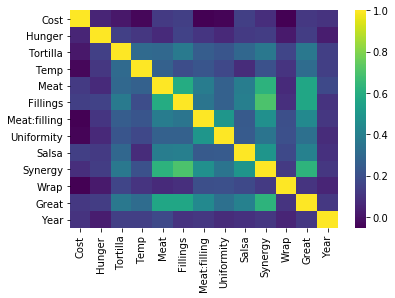

In [34]:
# check correlation between features 
correl = df.corr()

import seaborn as sns
sns.heatmap(correl,cmap='viridis',robust=True)
plt.show()

In [0]:
df.columns

Index(['Cost', 'Hunger', 'Tortilla', 'Temp', 'Meat', 'Fillings',
       'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap', 'Great',
       'Year'],
      dtype='object')

In [0]:
df.isnull().sum()

In [0]:
# 2016 & earlier. Validate on 2017. Test on 2018 & later.
# Train-test split 

train = df[df['Year'] <= 2016]
val = df[df['Year'] == 2017]
test = df[df['Year'] >= 2018]

In [0]:
# Majority class baseline 
target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)

False    0.590604
True     0.409396
Name: Great, dtype: float64

In [0]:
# Logistic Regression 
from sklearn.linear_model import LogisticRegression

In [0]:
#  Specify features and target 
features = ['Cost', 'Hunger', 'Tortilla', 'Temp', 'Meat', 'Fillings',
       'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap','Year']
target = 'Great'

# create subset of X and Y from train dataframe 
x_train = train[features]
y_train = train[target]

# create subset of xX and Y from validation dataframe 
x_val = val[features]
y_val = val[target]


In [0]:
# Libraries for one-hot encoding and preprocessing
import category_encoders as ce 
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

In [0]:
# Transform categorical data into binary using xtrain and xval 
encoder = ce.OneHotEncoder(use_cat_names=True)
x_train_encoded = encoder.fit_transform(x_train)
x_val_encoded = encoder.transform(x_val)

In [0]:
# Impute missing values with mean using encoded xtrain and ytrain
imputer = SimpleImputer(strategy='mean')
x_train_imputed = imputer.fit_transform(x_train_encoded)
x_val_imputed = imputer.transform(x_val_encoded)

In [0]:
# standardize 
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_imputed)
x_val_scaled = scaler.transform(x_val_imputed)

In [19]:
# Logistic regression 
# fit model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(x_train_scaled,y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
model.coef_

array([[0.31495139, 0.17846011, 0.64961359, 0.61733901, 1.24013741,
        1.16171182, 1.30969946, 0.00440834, 0.32346302, 1.68896249,
        0.23516199, 0.00418121]])

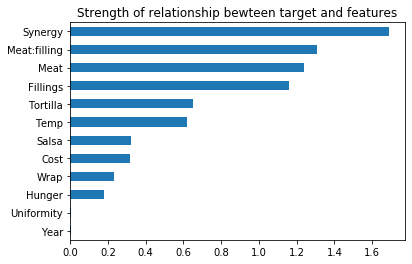

In [26]:
# plot coefficients 

import matplotlib.pyplot as plt
%matplotlib inline
plt.title("Strength of relationship bewteen target and features")
coefficients = pd.Series(model.coef_[0], x_train_encoded.columns)
coefficients.sort_values().plot.barh();

In [23]:
# Apply trained model on validation set to make a prediction 
y_pred = model.predict(x_val_scaled)

# compare target prediction to trained model using accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(y_val,y_pred)

0.8352941176470589

In [24]:
test.head()

,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Great,Year
77,8.00,4.0,4.5,5.0,5.0,5.0,4.5,5.0,3.0,5.0,5.0,True,2026
386,7.25,4.0,4.0,5.0,4.0,5.0,5.0,3.0,3.0,4.0,5.0,False,2018
387,4.19,3.0,3.0,5.0,2.0,2.0,4.0,1.0,4.0,3.0,4.0,False,2018
388,7.00,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,True,2018
389,8.50,4.0,4.0,4.0,3.0,3.5,1.0,2.0,3.0,3.0,1.0,False,2018


In [0]:
# compare model's test accuracy on test data 
# repeat encoding, imputation, and preprocessing
x_test = test[features]
y_test = test[target]
x_test_encoded = encoder.transform(x_test)
x_test_imputed = imputer.transform(x_test_encoded)
x_test_scaled = scaler.transform(x_test_imputed)
y_pred = model.predict(x_test_scaled)

In [28]:
# Get model test accuracy 
accuracy_score(y_test,y_pred)

0.7894736842105263